In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from mlxtend.feature_selection import ColumnSelector
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

### 优惠券特征的提取

+ 历史出现次数
+ 历史核销次数
+ 历史核销率
+ 历史核销时间率
+ 历史上用户领取该优惠券次数
+ 历史上用户消费该优惠券次数
+ 历史上用户对该优惠券的核销率

In [2]:
base_features_df = pd.read_csv('../features/lcm_base_features.csv')

In [3]:
base_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053282 entries, 0 to 1053281
Data columns (total 14 columns):
User_id              1053282 non-null int64
Merchant_id          1053282 non-null float64
Coupon_id            1053282 non-null float64
Distance             1053282 non-null float64
Date_received        1053282 non-null float64
Is_in_day_consume    1053282 non-null float64
Discount             1053282 non-null float64
Base_consume         1053282 non-null float64
Discount_money       1053282 non-null float64
Day_in_month         1053282 non-null float64
Day_in_week          1053282 non-null float64
Coupon_type          1053282 non-null float64
Offline_consume      1053282 non-null float64
Duration             1053282 non-null float64
dtypes: float64(13), int64(1)
memory usage: 112.5 MB


In [4]:
df = base_features_df[base_features_df['Date_received']< 20160501]

In [5]:
def join(df, col, series, key):
    return multi_join(df, col, series, [key])

def multi_join(df, col, series, keys):
    t = series.to_frame()
    t.columns = [col]
    
    return pd.merge(df, t, on=keys, how='left')

In [6]:
def receive_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Date_received']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Date_received']>0][target].groupby(groupby).size()

def cousume_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Offline_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Offline_consume']>0][target].groupby(groupby).size()

def used_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Is_in_day_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Is_in_day_consume']>0][target].groupby(groupby).size()

def cal_user_used_coupon_rate(row):
    return row.User_used_count/row.User_receive_count

def cal_user_not_used_conpon_count(row):
    return row.User_receive_count - row.User_used_count

def extract_info(df, target, type, groupby, column_name, is_dup=True):
    factory = {
        'receive_type': receive_count,
        'used_type': used_count
    }
    
    target_df = df[groupby].drop_duplicates()
    series = factory[type](df, target, groupby, is_dup)
    
    tdf = multi_join(target_df, column_name, series, groupby)
    tdf = tdf.fillna(0)
    
    mean = tdf[column_name].mean()
    tdf[column_name+'_occ'] = tdf[column_name] / mean
    return tdf[groupby + [column_name, column_name+'_occ']]

In [7]:
class GroupbyExtractor(TransformerMixin):
    def __init__(self, fn, target, type, groupby, column_name):
        self.fn = fn
        self.target = target
        self.type = type
        self.groupby = groupby
        self.column_name = column_name
    
    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, **transform_params):
        return self.fn(X, self.target, self.type, self.groupby, self.column_name)

In [8]:
keys = ['Coupon_id']
coupon_features_df = df[['Coupon_id']].drop_duplicates()

coupon_features_df = pd.merge(coupon_features_df, extract_info(df, ['Coupon_id'], 'receive_type', keys, 'Coupon_receive_count', False), on=keys, how='left')
coupon_features_df = pd.merge(coupon_features_df, extract_info(df, ['Coupon_id'], 'used_type', keys, 'Coupon_used_count', False), on=keys, how='left')
coupon_features_df = pd.merge(coupon_features_df, extract_info(df, ['Coupon_id', 'User_id'], 'receive_type', keys, 'Coupon_diff_user_receive_count'), on=keys, how='left')
coupon_features_df = pd.merge(coupon_features_df, extract_info(df, ['Coupon_id', 'User_id'], 'used_type', keys, 'Coupon_diff_user_used_count'), on=keys, how='left')

for i in range(0, 11, 1):
    
    coupon_features_df = pd.merge(
        coupon_features_df, 
        extract_info(
            df[df['Distance'] == i], 
            ['Coupon_id', 'Distance'], 
            'receive_type', 
            keys, 
            'Coupon_receive_distance_%s_count' % (i),
            False
        ), 
        on=keys, how='left'
    )
    
    coupon_features_df = pd.merge(
        coupon_features_df, 
        extract_info(
            df[df['Distance'] == i], 
            ['Coupon_id', 'Distance'], 
            'used_type', 
            keys, 
            'Coupon_used_distance_%s_count' % (i),
            False
        ), on=keys, how='left')
    
    coupon_features_df['Coupon_used_distance_%s_rate' % (i)] = coupon_features_df['Coupon_used_distance_%s_count' % (i)] / coupon_features_df['Coupon_used_count']

coupon_features_df['Coupon_used_rate'] = coupon_features_df['Coupon_used_count'] / coupon_features_df['Coupon_receive_count']

user_count = df['User_id'].unique().size
coupon_features_df['Coupon_diff_user_receive_rate'] = coupon_features_df['Coupon_diff_user_receive_count'] / user_count
coupon_features_df['Coupon_diff_user_used_rate'] = coupon_features_df['Coupon_diff_user_used_count'] / user_count

coupon_features_df = coupon_features_df.fillna(0)

coupon_features_df['Coupon_used_rate_occ'] = coupon_features_df['Coupon_used_rate'] / coupon_features_df['Coupon_used_rate'].mean()

In [9]:
t = base_features_df[['Coupon_id', 'Distance']].groupby('Coupon_id').agg(['mean', 'max', 'min'])
t.columns = ["_".join(x) for x in t.columns.ravel()]
coupon_features_df = pd.merge(coupon_features_df, t, on=keys, how='left')

In [10]:
coupon_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4483 entries, 0 to 4482
Data columns (total 71 columns):
Coupon_id                               4483 non-null float64
Coupon_receive_count                    4483 non-null int64
Coupon_receive_count_occ                4483 non-null float64
Coupon_used_count                       4483 non-null float64
Coupon_used_count_occ                   4483 non-null float64
Coupon_diff_user_receive_count          4483 non-null int64
Coupon_diff_user_receive_count_occ      4483 non-null float64
Coupon_diff_user_used_count             4483 non-null float64
Coupon_diff_user_used_count_occ         4483 non-null float64
Coupon_receive_distance_0_count         4483 non-null float64
Coupon_receive_distance_0_count_occ     4483 non-null float64
Coupon_used_distance_0_count            4483 non-null float64
Coupon_used_distance_0_count_occ        4483 non-null float64
Coupon_used_distance_0_rate             4483 non-null float64
Coupon_receive_distance_1_cou

In [11]:
coupon_features_df.to_csv('../features/lcm_coupon_features.csv', index=False, header=True)

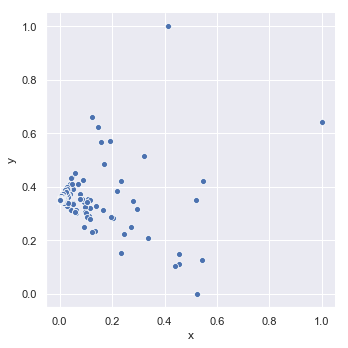

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

tdf = pd.read_csv('../features/lcm_coupon_features.csv')
tdf = tdf.drop(['Coupon_id'], axis=1)

ipipe = Pipeline([
    ('pca', PCA(n_components=2)),
    ('scale', MinMaxScaler()),
])

ipipe.fit(tdf)
output = ipipe.transform(tdf)
output_df = pd.DataFrame(data=output, columns=['x', 'y'])

sns.relplot(x="x", y="y", data=output_df);